In [1]:
import os
import pandas as pd
import time
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tempfile import TemporaryDirectory
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

In [2]:
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)

True
2.4.1
12.1


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used: {device}")

Device used: cuda


In [4]:
images_folder_path = 'C:\\Irina\\dataset\\SemArt\\Images'
train_csv_path = 'C:\\Irina\\dataset\\SemArt\\semart_train.csv'
val_csv_path = 'C:\\Irina\\dataset\\SemArt\\semart_val.csv'
test_csv_path = 'C:\\Irina\\dataset\\SemArt\\semart_test.csv'

In [5]:
def load_csv(csv_path, images_folder_path):
    df = pd.read_csv(csv_path, sep='\t', encoding='ISO-8859-1')
    # Create the full image path
    df['image_path'] = df['IMAGE_FILE'].apply(lambda x: os.path.join(images_folder_path, x))
    return df[['image_path', 'SCHOOL', 'TYPE']]

train_df = load_csv(train_csv_path, images_folder_path)
val_df = load_csv(val_csv_path, images_folder_path)
test_df = load_csv(test_csv_path, images_folder_path)

In [7]:
school_encoder = LabelEncoder()
type_encoder = LabelEncoder()

train_df['SCHOOL'] = school_encoder.fit_transform(train_df['SCHOOL'])
train_df['TYPE'] = type_encoder.fit_transform(train_df['TYPE'])

val_df['SCHOOL'] = school_encoder.transform(val_df['SCHOOL'])
val_df['TYPE'] = type_encoder.transform(val_df['TYPE'])

test_df['SCHOOL'] = school_encoder.transform(test_df['SCHOOL'])
test_df['TYPE'] = type_encoder.transform(test_df['TYPE'])

In [8]:
num_classes_school = len(school_encoder.classes_)
num_classes_type = len(type_encoder.classes_)

print(f"Number of classes for SCHOOL: {num_classes_school}")
print(f"Number of classes for TYPE: {num_classes_type}")

Number of classes for SCHOOL: 26
Number of classes for TYPE: 10


In [9]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [10]:
class SEMARTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        school_label = self.dataframe.iloc[idx]['SCHOOL']
        type_label = self.dataframe.iloc[idx]['TYPE']

        return image, torch.tensor(school_label, dtype=torch.long), torch.tensor(type_label, dtype=torch.long)

In [11]:
# Create dataset instances
train_dataset = SEMARTDataset(train_df, transform=train_transforms)
val_dataset = SEMARTDataset(val_df, transform=val_test_transforms)
test_dataset = SEMARTDataset(test_df, transform=val_test_transforms)

# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

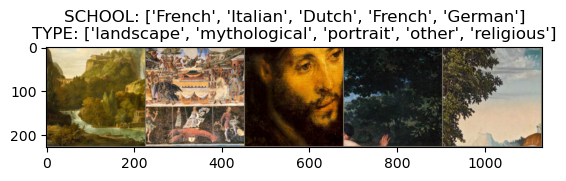

In [35]:
def imshow(inp, school_labels=None, type_labels=None):
    """Display images in a grid with school and type labels."""
    inp = inp.numpy().transpose((1, 2, 0))  #
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Reverse normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    # Display labels if provided
    if school_labels and type_labels:
        plt.title(f"SCHOOL: {school_labels}\nTYPE: {type_labels}")

    plt.pause(0.001)
    plt.show()


# Get a batch of training data
images, school_labels, type_labels = next(iter(train_loader))

# Select the first 5 images and their labels
images = images[:5]
school_labels = school_labels[:5]
type_labels = type_labels[:5]

# Make a grid from the 5 selected images
out = torchvision.utils.make_grid(images, nrow=5)

# Decode school and type labels for the first 5 images
school_labels_text = [school_encoder.classes_[label] for label in school_labels]
type_labels_text = [type_encoder.classes_[label] for label in type_labels]

# Display the grid of 5 images with the decoded labels
imshow(out, school_labels=school_labels_text, type_labels=type_labels_text)

In [ ]:
!pip install wandb

In [37]:
import wandb
wandb.login()

# Inițializarea proiectului
wandb.init(
    project="FESemArtDataset",  # Numele proiectului
    name="ResNet18-FixedFeatureExtractor",  # Numele experimentului
    config={
        "learning_rate": 0.001,
        "epochs": 25,
        "batch_size": batch_size,
        "patience": 7
    }
)





wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [25]:
from tqdm import tqdm

def train_model(model, criterion_school, criterion_type, optimizer, scheduler, drive_save_path, patience = 7, num_epochs=25):
    since = time.time()

    # Initialize best accuracy
    best_acc = 0.0
    no_improve_count = 0

    # Save the initial model state directly to Google Drive
    best_model_params_path = drive_save_path
    torch.save(model.state_dict(), best_model_params_path)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects_school = 0  # number of correct predictions for school
            running_corrects_type = 0  # number of correct predictions for type

            # Iterate over data
            for inputs, school_labels, type_labels in tqdm(dataloaders[phase], desc=f"{phase} Phase"):  # iteration over batches
                inputs = inputs.to(device)
                school_labels = school_labels.to(device)
                type_labels = type_labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):  # Only track gradients in training
                    # Forward pass to get outputs for both tasks
                    outputs = model(inputs)
                    outputs_school = outputs[:, :num_classes_school]  # Primele num_classes_school coloane
                    outputs_type = outputs[:, num_classes_school:]

                    # Compute losses for both tasks
                    loss_school = criterion_school(outputs_school, school_labels)
                    loss_type = criterion_type(outputs_type, type_labels)

                    # Combine the losses
                    loss = 0.5 * loss_school + 0.5 * loss_type

                    # Backward + optimize if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Get predictions
                    _, preds_school = torch.max(outputs_school, 1)
                    _, preds_type = torch.max(outputs_type, 1)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects_school += torch.sum(preds_school == school_labels.data)
                running_corrects_type += torch.sum(preds_type == type_labels.data)

            # Compute epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc_school = running_corrects_school.double() / dataset_sizes[phase]
            epoch_acc_type = running_corrects_type.double() / dataset_sizes[phase]
            avg_acc = (epoch_acc_school + epoch_acc_type) / 2

            if phase == 'train':
                scheduler.step(avg_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} '
                  f'SCHOOL Acc: {epoch_acc_school:.4f} '
                  f'TYPE Acc: {epoch_acc_type:.4f} '
                  f'AVG Acc: {avg_acc:.4f}')

            wandb.log({
              f"{phase}_loss": epoch_loss,
              f"{phase}_school_acc": epoch_acc_school.item(),
              f"{phase}_type_acc": epoch_acc_type.item(),
              f"{phase}_avg_acc": avg_acc,
              "epoch": epoch
            })

            # Save the model if it's the best so far
            if phase == 'val':
                if avg_acc > best_acc:
                    best_acc = avg_acc
                    no_improve_count = 0  # Reset the counter
                    print(f"New best model found! Saving to {drive_save_path}")
                    torch.save(model.state_dict(), best_model_params_path)
                else:
                    no_improve_count += 1
                    print(f"No improvement. Patience counter: {no_improve_count}/{patience}")
                    if no_improve_count >= patience:
                        print(f"No improvement in {patience} epochs. Stopping training.")
                        break 

        if no_improve_count >= patience:
            break 

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Avg Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    wandb.finish()

    return model

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [14]:
from collections import Counter

# Calcularea frecvențelor claselor pentru SCHOOL și TYPE
school_counts = Counter(train_df['SCHOOL'])  # Număr de exemple pentru fiecare clasă în SCHOOL
type_counts = Counter(train_df['TYPE'])  # Număr de exemple pentru fiecare clasă în TYPE

# Obținerea numărului total de clase pentru fiecare sarcină
num_classes_school_train = len(school_counts)
num_classes_type_train = len(type_counts)

# Conversia count-urilor în tensor ordonat după indexul claselor
class_counts_school = torch.tensor([school_counts[i] for i in range(num_classes_school_train)], dtype=torch.float)
class_counts_type = torch.tensor([type_counts[i] for i in range(num_classes_type_train)], dtype=torch.float)

# Calcularea ponderilor invers proporționale cu frecvențele claselor
weights_school = 1.0 / class_counts_school
weights_school = weights_school / weights_school.sum()  # Normalizarea ponderilor

weights_type = 1.0 / class_counts_type
weights_type = weights_type / weights_type.sum()  # Normalizarea ponderilor

# Crearea unui tabel pentru ponderi și etichete
weights_school_df = pd.DataFrame({
    'Class_Label': [school_encoder.inverse_transform([i])[0] for i in range(num_classes_school)],
    'Weight': weights_school.tolist(),
    'Count': class_counts_school.tolist()
})

weights_type_df = pd.DataFrame({
    'Class_Label': [type_encoder.inverse_transform([i])[0] for i in range(num_classes_type)],
    'Weight': weights_type.tolist(),
    'Count': class_counts_type.tolist()
})

print("Ponderi pentru SCHOOL:")
print(weights_school_df)

print("\nPonderi pentru TYPE:")
print(weights_type_df)


Ponderi pentru SCHOOL:
    Class_Label    Weight   Count
0             0  0.010353   113.0
1             1  0.005416   216.0
2             2  0.025999    45.0
3             3  0.040343    29.0
4             4  0.033427    35.0
5             5  0.012446    94.0
6             6  0.000397  2948.0
7             7  0.002847   411.0
8             8  0.233988     5.0
9             9  0.000580  2016.0
10           10  0.000458  2556.0
11           11  0.000997  1173.0
12           12  0.031620    37.0
13           13  0.006573   178.0
14           14  0.055711    21.0
15           15  0.000146  8011.0
16           16  0.005391   217.0
17           17  0.064997    18.0
18           18  0.053179    22.0
19           19  0.073121    16.0
20           20  0.233988     5.0
21           21  0.017205    68.0
22           22  0.025433    46.0
23           23  0.001373   852.0
24           24  0.050867    23.0
25           25  0.013145    89.0

Ponderi pentru TYPE:
   Class_Label    Weight   Count
0   

In [21]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in resnet18.parameters(): # freeze all layers except the final fully connected layers
    param.requires_grad = False

num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 256),  # Un strat ascuns intermediar
    nn.ReLU(),
    nn.Linear(256, num_classes_school + num_classes_type)  # Ieșiri pentru SCHOOL și TYPE
)

resnet18 = resnet18.to(device)

# Crearea funcțiilor de pierdere cu ponderi
criterion_school = torch.nn.CrossEntropyLoss(weight=weights_school.to(device))
criterion_type = torch.nn.CrossEntropyLoss(weight=weights_type.to(device))
optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [43]:
drive_save_path = 'C:\\Irina\\model\\best_model_params.pth'
resnet18 = train_model(resnet18, criterion_school, criterion_type, optimizer, scheduler, drive_save_path, patience = 7, num_epochs=25)

Epoch 0/24
----------


train Phase: 100%|██████████| 1203/1203 [11:11<00:00,  1.79it/s]


train Loss: 2.3559 SCHOOL Acc: 0.2469 TYPE Acc: 0.4622


val Phase: 100%|██████████| 67/67 [00:42<00:00,  1.56it/s]


val Loss: 2.0987 SCHOOL Acc: 0.3068 TYPE Acc: 0.5659
New best model found! Saving to C:\Irina\model\best_model_params.pth

Epoch 1/24
----------


train Phase: 100%|██████████| 1203/1203 [10:32<00:00,  1.90it/s]


train Loss: 2.1225 SCHOOL Acc: 0.2927 TYPE Acc: 0.5385


val Phase: 100%|██████████| 67/67 [00:38<00:00,  1.76it/s]


val Loss: 1.9916 SCHOOL Acc: 0.3003 TYPE Acc: 0.5893
New best model found! Saving to C:\Irina\model\best_model_params.pth

Epoch 2/24
----------


train Phase: 100%|██████████| 1203/1203 [10:08<00:00,  1.98it/s]


train Loss: 2.0350 SCHOOL Acc: 0.3023 TYPE Acc: 0.5539


val Phase: 100%|██████████| 67/67 [00:42<00:00,  1.58it/s]


val Loss: 1.9336 SCHOOL Acc: 0.3152 TYPE Acc: 0.5893
New best model found! Saving to C:\Irina\model\best_model_params.pth

Epoch 3/24
----------


train Phase: 100%|██████████| 1203/1203 [10:02<00:00,  2.00it/s]


train Loss: 2.0000 SCHOOL Acc: 0.3041 TYPE Acc: 0.5572


val Phase: 100%|██████████| 67/67 [00:42<00:00,  1.57it/s]


val Loss: 1.9021 SCHOOL Acc: 0.3143 TYPE Acc: 0.6408
New best model found! Saving to C:\Irina\model\best_model_params.pth

Epoch 4/24
----------


train Phase: 100%|██████████| 1203/1203 [20:32<00:00,  1.02s/it]   


train Loss: 1.9617 SCHOOL Acc: 0.3121 TYPE Acc: 0.5607


val Phase: 100%|██████████| 67/67 [00:30<00:00,  2.21it/s]


val Loss: 1.8697 SCHOOL Acc: 0.2891 TYPE Acc: 0.5940
No improvement. Patience counter: 1/7

Epoch 5/24
----------


train Phase: 100%|██████████| 1203/1203 [10:12<00:00,  1.96it/s]


train Loss: 1.9340 SCHOOL Acc: 0.3084 TYPE Acc: 0.5604


val Phase: 100%|██████████| 67/67 [00:34<00:00,  1.95it/s]


val Loss: 1.8270 SCHOOL Acc: 0.2834 TYPE Acc: 0.6193
No improvement. Patience counter: 2/7

Epoch 6/24
----------


train Phase: 100%|██████████| 1203/1203 [10:10<00:00,  1.97it/s]


train Loss: 1.9077 SCHOOL Acc: 0.3191 TYPE Acc: 0.5749


val Phase: 100%|██████████| 67/67 [00:39<00:00,  1.68it/s]


val Loss: 1.9015 SCHOOL Acc: 0.2554 TYPE Acc: 0.6183
No improvement. Patience counter: 3/7

Epoch 7/24
----------


train Phase: 100%|██████████| 1203/1203 [10:26<00:00,  1.92it/s]


train Loss: 1.8449 SCHOOL Acc: 0.3397 TYPE Acc: 0.5834


val Phase: 100%|██████████| 67/67 [00:30<00:00,  2.21it/s]


val Loss: 1.8205 SCHOOL Acc: 0.3695 TYPE Acc: 0.6249
New best model found! Saving to C:\Irina\model\best_model_params.pth

Epoch 8/24
----------


train Phase: 100%|██████████| 1203/1203 [09:41<00:00,  2.07it/s]


train Loss: 1.8167 SCHOOL Acc: 0.3438 TYPE Acc: 0.5828


val Phase: 100%|██████████| 67/67 [00:37<00:00,  1.79it/s]


val Loss: 1.8052 SCHOOL Acc: 0.3424 TYPE Acc: 0.6109
No improvement. Patience counter: 1/7

Epoch 9/24
----------


train Phase: 100%|██████████| 1203/1203 [08:39<00:00,  2.32it/s]


train Loss: 1.8194 SCHOOL Acc: 0.3410 TYPE Acc: 0.5858


val Phase: 100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


val Loss: 1.7928 SCHOOL Acc: 0.3246 TYPE Acc: 0.6305
No improvement. Patience counter: 2/7

Epoch 10/24
----------


train Phase: 100%|██████████| 1203/1203 [57:19<00:00,  2.86s/it]    


train Loss: 1.7977 SCHOOL Acc: 0.3499 TYPE Acc: 0.5813


val Phase: 100%|██████████| 67/67 [00:41<00:00,  1.60it/s]


val Loss: 1.8027 SCHOOL Acc: 0.3293 TYPE Acc: 0.6127
No improvement. Patience counter: 3/7

Epoch 11/24
----------


train Phase: 100%|██████████| 1203/1203 [10:00<00:00,  2.00it/s]


train Loss: 1.8185 SCHOOL Acc: 0.3419 TYPE Acc: 0.5834


val Phase: 100%|██████████| 67/67 [00:38<00:00,  1.74it/s]


val Loss: 1.7979 SCHOOL Acc: 0.3405 TYPE Acc: 0.6183
No improvement. Patience counter: 4/7

Epoch 12/24
----------


train Phase: 100%|██████████| 1203/1203 [10:16<00:00,  1.95it/s]


train Loss: 1.8027 SCHOOL Acc: 0.3433 TYPE Acc: 0.5877


val Phase: 100%|██████████| 67/67 [00:39<00:00,  1.68it/s]


val Loss: 1.7916 SCHOOL Acc: 0.3265 TYPE Acc: 0.6230
No improvement. Patience counter: 5/7

Epoch 13/24
----------


train Phase: 100%|██████████| 1203/1203 [09:57<00:00,  2.01it/s]


train Loss: 1.8076 SCHOOL Acc: 0.3440 TYPE Acc: 0.5876


val Phase: 100%|██████████| 67/67 [00:30<00:00,  2.20it/s]


val Loss: 1.7822 SCHOOL Acc: 0.3293 TYPE Acc: 0.6034
No improvement. Patience counter: 6/7

Epoch 14/24
----------


train Phase: 100%|██████████| 1203/1203 [09:23<00:00,  2.13it/s]


train Loss: 1.7909 SCHOOL Acc: 0.3353 TYPE Acc: 0.5841


val Phase: 100%|██████████| 67/67 [00:40<00:00,  1.64it/s]


val Loss: 1.7913 SCHOOL Acc: 0.3265 TYPE Acc: 0.6193
No improvement. Patience counter: 7/7

Epoch 15/24
----------


train Phase: 100%|██████████| 1203/1203 [10:06<00:00,  1.98it/s]


train Loss: 1.7897 SCHOOL Acc: 0.3450 TYPE Acc: 0.5868


val Phase: 100%|██████████| 67/67 [00:30<00:00,  2.21it/s]


val Loss: 1.7804 SCHOOL Acc: 0.3368 TYPE Acc: 0.6277
No improvement. Patience counter: 8/7

Epoch 16/24
----------


train Phase: 100%|██████████| 1203/1203 [09:49<00:00,  2.04it/s]


train Loss: 1.7855 SCHOOL Acc: 0.3460 TYPE Acc: 0.5840


val Phase: 100%|██████████| 67/67 [00:39<00:00,  1.71it/s]


val Loss: 1.7919 SCHOOL Acc: 0.3377 TYPE Acc: 0.6193
No improvement. Patience counter: 9/7

Epoch 17/24
----------


train Phase:   1%|▏         | 18/1203 [00:09<10:44,  1.84it/s]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm

test_loss = 0.0
test_corrects_school = 0
test_corrects_type = 0

with torch.no_grad():
    for inputs, school_labels, type_labels in tqdm(dataloaders['test'], desc="Test Evaluation"):
        inputs = inputs.to(device)
        school_labels = school_labels.to(device)
        type_labels = type_labels.to(device)

        outputs = resnet18(inputs)
        outputs_school = outputs[:, :num_classes_school]
        outputs_type = outputs[:, num_classes_school:]

        loss_school = criterion_school(outputs_school, school_labels)
        loss_type = criterion_type(outputs_type, type_labels)
        loss = 0.5 * loss_school + 0.5 * loss_type

        _, preds_school = torch.max(outputs_school, 1)
        _, preds_type = torch.max(outputs_type, 1)

        test_loss += loss.item() * inputs.size(0)
        test_corrects_school += torch.sum(preds_school == school_labels.data)
        test_corrects_type += torch.sum(preds_type == type_labels.data)

test_loss /= dataset_sizes['test']
test_acc_school = test_corrects_school.double() / dataset_sizes['test']
test_acc_type = test_corrects_type.double() / dataset_sizes['test']

print(f"Test Loss: {test_loss:.4f}")
print(f"SCHOOL Test Accuracy: {test_acc_school:.4f}")
print(f"TYPE Test Accuracy: {test_acc_type:.4f}")

In [30]:
import wandb
wandb.login()
wandb.init(
    project="FESemArtDataset",  # Numele proiectului
    name="ResNet18-FineTuningTry3",  # Numele experimentului
    config={
        "learning_rate": 0.0001,
        "epochs": 25,
        "batch_size": batch_size,
        "patience": 7
    }
)

In [31]:
resnet18_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

num_features = resnet18_ft.fc.in_features
resnet18_ft.fc = nn.Sequential(
    nn.Linear(num_features, 512),  # Un strat ascuns intermediar
    nn.ReLU(),
    nn.Linear(512, num_classes_school + num_classes_type)  # Ieșiri pentru SCHOOL și TYPE
)

resnet18_ft = resnet18_ft.to(device)
optimizer_ft = optim.Adam(resnet18_ft.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', patience=3, factor=0.5)

In [32]:
drive_save_path_ft = 'C:\\Irina\\model\\best_model_params_ft18.pth'
resnet18_ft = train_model(resnet18_ft, criterion_school, criterion_type, optimizer_ft, scheduler_ft, drive_save_path_ft, patience = 7, num_epochs=25)

Epoch 0/24
----------


train Phase: 100%|██████████| 602/602 [12:55<00:00,  1.29s/it]


train Loss: 2.2357 SCHOOL Acc: 0.2133 TYPE Acc: 0.5233 AVG Acc: 0.3683


val Phase: 100%|██████████| 34/34 [00:37<00:00,  1.12s/it]


val Loss: 1.9290 SCHOOL Acc: 0.2544 TYPE Acc: 0.5875 AVG Acc: 0.4210
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 1/24
----------


train Phase: 100%|██████████| 602/602 [12:14<00:00,  1.22s/it]


train Loss: 1.9643 SCHOOL Acc: 0.2905 TYPE Acc: 0.5871 AVG Acc: 0.4388


val Phase: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


val Loss: 1.8714 SCHOOL Acc: 0.3096 TYPE Acc: 0.6230 AVG Acc: 0.4663
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 2/24
----------


train Phase: 100%|██████████| 602/602 [13:02<00:00,  1.30s/it]


train Loss: 1.8536 SCHOOL Acc: 0.2939 TYPE Acc: 0.5971 AVG Acc: 0.4455


val Phase: 100%|██████████| 34/34 [00:38<00:00,  1.13s/it]


val Loss: 1.8057 SCHOOL Acc: 0.3854 TYPE Acc: 0.5931 AVG Acc: 0.4892
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 3/24
----------


train Phase: 100%|██████████| 602/602 [11:03<00:00,  1.10s/it]


train Loss: 1.7338 SCHOOL Acc: 0.3261 TYPE Acc: 0.6100 AVG Acc: 0.4680


val Phase: 100%|██████████| 34/34 [00:38<00:00,  1.14s/it]


val Loss: 1.8121 SCHOOL Acc: 0.3835 TYPE Acc: 0.6735 AVG Acc: 0.5285
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 4/24
----------


train Phase: 100%|██████████| 602/602 [13:06<00:00,  1.31s/it]


train Loss: 1.6556 SCHOOL Acc: 0.3313 TYPE Acc: 0.6258 AVG Acc: 0.4785


val Phase: 100%|██████████| 34/34 [00:38<00:00,  1.12s/it]


val Loss: 1.8635 SCHOOL Acc: 0.3779 TYPE Acc: 0.6698 AVG Acc: 0.5239
No improvement. Patience counter: 1/7

Epoch 5/24
----------


train Phase: 100%|██████████| 602/602 [12:42<00:00,  1.27s/it]


train Loss: 1.5874 SCHOOL Acc: 0.3417 TYPE Acc: 0.6273 AVG Acc: 0.4845


val Phase: 100%|██████████| 34/34 [00:37<00:00,  1.10s/it]


val Loss: 1.8795 SCHOOL Acc: 0.3770 TYPE Acc: 0.6763 AVG Acc: 0.5267
No improvement. Patience counter: 2/7

Epoch 6/24
----------


train Phase: 100%|██████████| 602/602 [12:19<00:00,  1.23s/it]


train Loss: 1.4995 SCHOOL Acc: 0.3510 TYPE Acc: 0.6331 AVG Acc: 0.4920


val Phase: 100%|██████████| 34/34 [00:30<00:00,  1.10it/s]


val Loss: 1.7929 SCHOOL Acc: 0.3414 TYPE Acc: 0.6848 AVG Acc: 0.5131
No improvement. Patience counter: 3/7

Epoch 7/24
----------


train Phase: 100%|██████████| 602/602 [12:04<00:00,  1.20s/it]


train Loss: 1.4347 SCHOOL Acc: 0.3669 TYPE Acc: 0.6457 AVG Acc: 0.5063


val Phase: 100%|██████████| 34/34 [00:37<00:00,  1.10s/it]


val Loss: 1.8426 SCHOOL Acc: 0.3704 TYPE Acc: 0.6595 AVG Acc: 0.5150
No improvement. Patience counter: 4/7

Epoch 8/24
----------


train Phase: 100%|██████████| 602/602 [12:46<00:00,  1.27s/it]


train Loss: 1.3762 SCHOOL Acc: 0.3822 TYPE Acc: 0.6460 AVG Acc: 0.5141


val Phase: 100%|██████████| 34/34 [00:36<00:00,  1.08s/it]


val Loss: 1.8727 SCHOOL Acc: 0.2881 TYPE Acc: 0.6679 AVG Acc: 0.4780
No improvement. Patience counter: 5/7

Epoch 9/24
----------


train Phase: 100%|██████████| 602/602 [12:47<00:00,  1.27s/it]


train Loss: 1.2745 SCHOOL Acc: 0.3937 TYPE Acc: 0.6577 AVG Acc: 0.5257


val Phase: 100%|██████████| 34/34 [00:37<00:00,  1.10s/it]


val Loss: 1.9568 SCHOOL Acc: 0.3050 TYPE Acc: 0.6548 AVG Acc: 0.4799
No improvement. Patience counter: 6/7

Epoch 10/24
----------


train Phase: 100%|██████████| 602/602 [11:22<00:00,  1.13s/it]


train Loss: 1.2606 SCHOOL Acc: 0.3920 TYPE Acc: 0.6553 AVG Acc: 0.5236


val Phase: 100%|██████████| 34/34 [00:36<00:00,  1.09s/it]


val Loss: 1.9366 SCHOOL Acc: 0.3882 TYPE Acc: 0.6782 AVG Acc: 0.5332
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 11/24
----------


train Phase: 100%|██████████| 602/602 [12:44<00:00,  1.27s/it]


train Loss: 1.1989 SCHOOL Acc: 0.4043 TYPE Acc: 0.6641 AVG Acc: 0.5342


val Phase: 100%|██████████| 34/34 [00:36<00:00,  1.07s/it]


val Loss: 2.0339 SCHOOL Acc: 0.4228 TYPE Acc: 0.6614 AVG Acc: 0.5421
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 12/24
----------


train Phase: 100%|██████████| 602/602 [12:46<00:00,  1.27s/it]


train Loss: 1.1441 SCHOOL Acc: 0.4120 TYPE Acc: 0.6706 AVG Acc: 0.5413


val Phase: 100%|██████████| 34/34 [00:36<00:00,  1.09s/it]


val Loss: 1.9010 SCHOOL Acc: 0.4312 TYPE Acc: 0.6717 AVG Acc: 0.5514
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 13/24
----------


train Phase: 100%|██████████| 602/602 [12:45<00:00,  1.27s/it]


train Loss: 1.1035 SCHOOL Acc: 0.4330 TYPE Acc: 0.6740 AVG Acc: 0.5535


val Phase: 100%|██████████| 34/34 [00:37<00:00,  1.10s/it]


val Loss: 1.9241 SCHOOL Acc: 0.4060 TYPE Acc: 0.6922 AVG Acc: 0.5491
No improvement. Patience counter: 1/7

Epoch 14/24
----------


train Phase: 100%|██████████| 602/602 [12:06<00:00,  1.21s/it]


train Loss: 1.0443 SCHOOL Acc: 0.4377 TYPE Acc: 0.6791 AVG Acc: 0.5584


val Phase: 100%|██████████| 34/34 [00:30<00:00,  1.10it/s]


val Loss: 2.0268 SCHOOL Acc: 0.4022 TYPE Acc: 0.6688 AVG Acc: 0.5355
No improvement. Patience counter: 2/7

Epoch 15/24
----------


train Phase: 100%|██████████| 602/602 [12:35<00:00,  1.25s/it]


train Loss: 1.0655 SCHOOL Acc: 0.4427 TYPE Acc: 0.6805 AVG Acc: 0.5616


val Phase: 100%|██████████| 34/34 [00:30<00:00,  1.11it/s]


val Loss: 1.9447 SCHOOL Acc: 0.3817 TYPE Acc: 0.6670 AVG Acc: 0.5243
No improvement. Patience counter: 3/7

Epoch 16/24
----------


train Phase: 100%|██████████| 602/602 [12:08<00:00,  1.21s/it]


train Loss: 1.0191 SCHOOL Acc: 0.4493 TYPE Acc: 0.6856 AVG Acc: 0.5675


val Phase: 100%|██████████| 34/34 [00:36<00:00,  1.08s/it]


val Loss: 1.9706 SCHOOL Acc: 0.4097 TYPE Acc: 0.6857 AVG Acc: 0.5477
No improvement. Patience counter: 4/7

Epoch 17/24
----------


train Phase: 100%|██████████| 602/602 [12:45<00:00,  1.27s/it]


train Loss: 1.0046 SCHOOL Acc: 0.4615 TYPE Acc: 0.6892 AVG Acc: 0.5754


val Phase: 100%|██████████| 34/34 [00:37<00:00,  1.11s/it]


val Loss: 2.2022 SCHOOL Acc: 0.4294 TYPE Acc: 0.6782 AVG Acc: 0.5538
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 18/24
----------


train Phase: 100%|██████████| 602/602 [12:08<00:00,  1.21s/it]


train Loss: 0.9620 SCHOOL Acc: 0.4752 TYPE Acc: 0.6962 AVG Acc: 0.5857


val Phase: 100%|██████████| 34/34 [00:36<00:00,  1.08s/it]


val Loss: 2.1952 SCHOOL Acc: 0.4341 TYPE Acc: 0.6810 AVG Acc: 0.5575
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 19/24
----------


train Phase: 100%|██████████| 602/602 [12:47<00:00,  1.28s/it]


train Loss: 0.9357 SCHOOL Acc: 0.4733 TYPE Acc: 0.6953 AVG Acc: 0.5843


val Phase: 100%|██████████| 34/34 [00:36<00:00,  1.08s/it]


val Loss: 2.0186 SCHOOL Acc: 0.4359 TYPE Acc: 0.6745 AVG Acc: 0.5552
No improvement. Patience counter: 1/7

Epoch 20/24
----------


train Phase: 100%|██████████| 602/602 [11:48<00:00,  1.18s/it]


train Loss: 0.8822 SCHOOL Acc: 0.4835 TYPE Acc: 0.7037 AVG Acc: 0.5936


val Phase: 100%|██████████| 34/34 [00:37<00:00,  1.09s/it]


val Loss: 2.1195 SCHOOL Acc: 0.4500 TYPE Acc: 0.6932 AVG Acc: 0.5716
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 21/24
----------


train Phase: 100%|██████████| 602/602 [12:05<00:00,  1.21s/it]


train Loss: 0.8698 SCHOOL Acc: 0.4962 TYPE Acc: 0.7109 AVG Acc: 0.6035


val Phase: 100%|██████████| 34/34 [00:37<00:00,  1.10s/it]


val Loss: 2.2625 SCHOOL Acc: 0.4902 TYPE Acc: 0.6922 AVG Acc: 0.5912
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 22/24
----------


train Phase: 100%|██████████| 602/602 [12:05<00:00,  1.20s/it]


train Loss: 0.8972 SCHOOL Acc: 0.4915 TYPE Acc: 0.7084 AVG Acc: 0.6000


val Phase: 100%|██████████| 34/34 [00:36<00:00,  1.09s/it]


val Loss: 2.2553 SCHOOL Acc: 0.4818 TYPE Acc: 0.7203 AVG Acc: 0.6010
New best model found! Saving to C:\Irina\model\best_model_params_ft18.pth

Epoch 23/24
----------


train Phase: 100%|██████████| 602/602 [12:50<00:00,  1.28s/it]


train Loss: 0.8642 SCHOOL Acc: 0.5055 TYPE Acc: 0.7140 AVG Acc: 0.6098


val Phase: 100%|██████████| 34/34 [00:36<00:00,  1.09s/it]


val Loss: 2.2794 SCHOOL Acc: 0.4500 TYPE Acc: 0.7156 AVG Acc: 0.5828
No improvement. Patience counter: 1/7

Epoch 24/24
----------


train Phase: 100%|██████████| 602/602 [12:47<00:00,  1.27s/it]


train Loss: 0.8770 SCHOOL Acc: 0.4842 TYPE Acc: 0.7119 AVG Acc: 0.5980


val Phase: 100%|██████████| 34/34 [00:37<00:00,  1.10s/it]


val Loss: 2.0209 SCHOOL Acc: 0.4537 TYPE Acc: 0.6950 AVG Acc: 0.5744
No improvement. Patience counter: 2/7

Training complete in 326m 6s
Best val Avg Acc: 0.601029


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
train_avg_acc,▁▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
train_school_acc,▁▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███▇
train_type_acc,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
val_avg_acc,▁▃▄▅▅▅▅▅▃▃▅▆▆▆▅▅▆▆▆▆▇██▇▇
val_loss,▃▂▁▁▂▂▁▂▂▃▃▄▃▃▄▃▄▇▇▄▆███▄
val_school_acc,▁▃▅▅▅▅▄▄▂▂▅▆▆▅▅▅▆▆▆▆▇██▇▇
val_type_acc,▁▃▁▆▅▆▆▅▅▅▆▅▅▇▅▅▆▆▆▆▇▇██▇
epoch,24
train_avg_acc,0.598


In [29]:
wandb.finish()

epoch,▁▁
train_avg_acc,▁
train_loss,▁
train_school_acc,▁
train_type_acc,▁
val_avg_acc,▁
val_loss,▁
val_school_acc,▁
val_type_acc,▁
epoch,0
train_avg_acc,0.43104


In [33]:
from tqdm import tqdm

test_loss = 0.0
test_corrects_school = 0
test_corrects_type = 0

with torch.no_grad():
    for inputs, school_labels, type_labels in tqdm(dataloaders['test'], desc="Test Evaluation"):
        inputs = inputs.to(device)
        school_labels = school_labels.to(device)
        type_labels = type_labels.to(device)

        outputs = resnet18_ft(inputs)
        outputs_school = outputs[:, :num_classes_school]
        outputs_type = outputs[:, num_classes_school:]

        loss_school = criterion_school(outputs_school, school_labels)
        loss_type = criterion_type(outputs_type, type_labels)
        loss = 0.5 * loss_school + 0.5 * loss_type

        _, preds_school = torch.max(outputs_school, 1)
        _, preds_type = torch.max(outputs_type, 1)

        test_loss += loss.item() * inputs.size(0)
        test_corrects_school += torch.sum(preds_school == school_labels.data)
        test_corrects_type += torch.sum(preds_type == type_labels.data)

test_loss /= dataset_sizes['test']
test_acc_school = test_corrects_school.double() / dataset_sizes['test']
test_acc_type = test_corrects_type.double() / dataset_sizes['test']

print(f"Test Loss: {test_loss:.4f}")
print(f"SCHOOL Test Accuracy: {test_acc_school:.4f}")
print(f"TYPE Test Accuracy: {test_acc_type:.4f}")

Test Evaluation: 100%|██████████| 34/34 [00:37<00:00,  1.11s/it]


Test Loss: 2.2091
SCHOOL Test Accuracy: 0.4930
TYPE Test Accuracy: 0.7100
